FrozenLake with Q-Learning

라이브러리 추가 및 파라미터 설정

In [7]:
# 라이브러리 추가(import)
import gym
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


# 파라미터 설정
num_episode = 20
is_video_save = True
fps = 5

avi_file_name = 'Q-rl-1.avi'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FrozenLake 시각화를 위한 함수 구현

In [8]:
# 전제적인 환경 및 상태을 그려주는 함수
def draw_state(state, q_table):
    img = np.zeros((401, 401, 3))

    # 배경 그리기
    for i in range(4):
        cv2.line(img, ((i+1)*100, 0), ((i+1)*100, 400), (255, 255, 255), 1)
        cv2.line(img, (0, (i+1)*100), (400, (i+1)*100), (255, 255, 255), 1)

    # 함정과 목표지점 그리기
    cv2.putText(img, 'H', (1*100+10, 1*100+80), cv2.FONT_HERSHEY_COMPLEX,
                3, (255, 0, 0))
    cv2.putText(img, 'H', (3*100+12, 1*100+80), cv2.FONT_HERSHEY_COMPLEX,
                3, (255, 0, 0))
    cv2.putText(img, 'H', (3*100+12, 2*100+80), cv2.FONT_HERSHEY_COMPLEX,
                3, (255, 0, 0))
    cv2.putText(img, 'H', (0*100+12, 3*100+80), cv2.FONT_HERSHEY_COMPLEX,
                3, (255, 0, 0))
    cv2.putText(img, 'G', (3*100+12, 3*100+80), cv2.FONT_HERSHEY_COMPLEX,
                3, (0, 255, 0))

    # Agent 위치 표시
    row = state//4
    col = state%4
    cv2.circle(img, (col*100+50, row*100+50), 15, (0, 0, 255), -1)

    # Q Table 표시
    for i in range(16):
        if (i == 5 or i == 7 or i == 11 or i == 12 or i == 15):
            continue
        row = i//4
        col = i%4
        cv2.putText(img, str(round(q_table[i][0], 3)), (col*100+1, row*100+55),
                    cv2.FONT_HERSHEY_COMPLEX, 0.3,
                    (255, 255, 255))
        cv2.putText(img, str(round(q_table[i][1], 3)), (col*100+40, row*100+90),
                    cv2.FONT_HERSHEY_COMPLEX, 0.3,
                    (255, 255, 255))
        cv2.putText(img, str(round(q_table[i][2], 3)), (col*100+70, row*100+55),
                    cv2.FONT_HERSHEY_COMPLEX, 0.3,
                    (255, 255, 255))
        cv2.putText(img, str(round(q_table[i][3], 3)), (col*100+40, row*100+10),
                    cv2.FONT_HERSHEY_COMPLEX, 0.3,
                    (255, 255, 255))
    return img


# 문자열을 적으면 이미지로 변경해 주는 함수
def draw_txt(txt):
    img = np.zeros((401, 401, 3))
    cv2.putText(img, txt, (10, 200), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255))
    return img

Q-Learning을 위한 설정 및 게임 진행

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


20번 시도 중 11.0번 성공!
성공률은 55.0% 입니다.


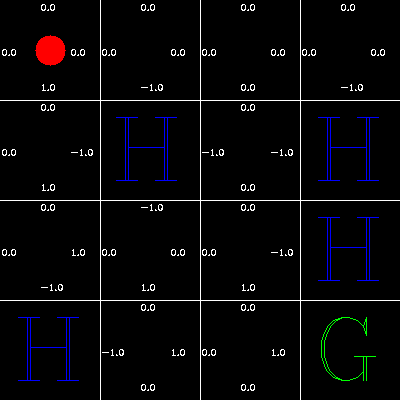

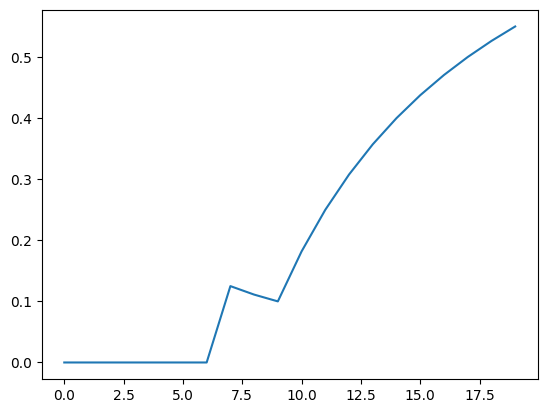

In [9]:
#FrozenLake 환경 생성
env = gym.make('FrozenLake-v1', is_slippery=False)

# Q-Table 만들기
q_table = np.zeros((16, 4))

# 에이전트가 움직이는 것과 Q-table변화를 확인하기 위한 영상
if (is_video_save):
    fcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter(avi_file_name, fcc, fps, (401, 401))

# 보상을 기록할 리스트 정의
reward_list = []
reward_100_average = []

# FrozenLake 게임 진행
for epi in range(num_episode):
    if (is_video_save):
        txt = 'Episode : '+str(epi)
        for _ in range(3):
            out.write(np.uint8(draw_txt(txt)))
    d = False
    total_reward = 0
    s = env.reset()
    # 게임이 종료될 때까지 반복
    while not d:
        if (is_video_save):
            out.write(np.uint8(draw_state(s, q_table)))
#########################################################################

        # 액션 4개 중 Q값이 가장 큰값을 선택한다
        # 만약 Q값이 큰 값이 여러개면 랜덤하게 선택한다.
        action = np.argmax(np.random.random((4,))*(q_table[s] == q_table[s].max()))

        # action을 취할 때마다 다음 위치, 보상 지정
        n_s, r, d, _ = env.step(action)

        # 새로 얻은 보상이 있다면 누적
        total_reward = total_reward+r

#########################################################################

        # 보상을 얻지 못했는데, 게임이 끝나버렸다면
        if (total_reward == 0 and d == True) :
          # 처벌 : 해당 액션에 대한 Q값을 -1로 지정해준다.
          q_table[s][action] = -1
          s = n_s
        else :
          # 보상을 얻었다면, 해당 액션에 대한 Q값을 보상만큼 더해준다.
          q_table[s][action] = r+np.max(q_table[n_s])
          s = n_s
          
#########################################################################

    reward_list.append(total_reward)

    if (is_video_save):
        out.write(np.uint8(draw_state(s, q_table)))
    if (total_reward == 1):
        txt = 'Success'
    else:
        txt = 'Fail'

    if (is_video_save):
        for _ in range(3):
            out.write(np.uint8(draw_txt(txt)))
    reward_100_average.append(np.average(reward_list[-100:]))

if (is_video_save):
    txt = 'Success : '+str(np.sum(reward_list))
    for _ in range(3):
        out.write(np.uint8(draw_txt(txt)))
    out.release()

print('{}번 시도 중 {}번 성공!'.format(num_episode, np.sum(reward_list)))
print('성공률은 {}% 입니다.'.format(round(np.sum(reward_list)/num_episode*100, 2)))
cv2_imshow(draw_state(0, q_table))
plt.plot(reward_100_average)